In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
%matplotlib inline

In [11]:
df=pd.read_csv('listings.csv')

In [3]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [4]:
for i in df.columns:
    print(f"{i:<32}" +' %  Nulls: ' + f"{str(int((df[i].isnull().sum()/len(df))*100)) : >10}")

id                               %  Nulls:          0
listing_url                      %  Nulls:          0
scrape_id                        %  Nulls:          0
last_scraped                     %  Nulls:          0
name                             %  Nulls:          0
summary                          %  Nulls:          4
space                            %  Nulls:         14
description                      %  Nulls:          0
experiences_offered              %  Nulls:          0
neighborhood_overview            %  Nulls:         27
notes                            %  Nulls:         42
transit                          %  Nulls:         24
thumbnail_url                    %  Nulls:          8
medium_url                       %  Nulls:          8
picture_url                      %  Nulls:          0
xl_picture_url                   %  Nulls:          8
host_id                          %  Nulls:          0
host_url                         %  Nulls:          0
host_name                   

In [12]:
df=df.drop(['listing_url','thumbnail_url','medium_url' , 'picture_url','xl_picture_url','scrape_id','last_scraped',
            'experiences_offered','picture_url','requires_license','license','jurisdiction_names','state','city','market'
            ,'smart_location','country_code','country','longitude','latitude','square_feet','has_availability',
            'calendar_last_scraped','host_url','host_name','host_location','host_about','host_thumbnail_url',
            'host_picture_url','street','availability_30','availability_60','availability_90','first_review',
            'last_review'],axis=1)

In [134]:
for i in df.columns:
    print(f"{i:<32}" +'  : '+ str(df[i].dtypes))

id                                : int64
neighborhood_overview             : object
host_id                           : int64
host_since                        : object
host_response_time                : object
host_response_rate                : object
host_acceptance_rate              : object
host_is_superhost                 : object
host_neighbourhood                : object
host_listings_count               : float64
host_total_listings_count         : float64
host_verifications                : object
host_has_profile_pic              : object
host_identity_verified            : object
neighbourhood                     : object
neighbourhood_cleansed            : object
neighbourhood_group_cleansed      : object
zipcode                           : object
is_location_exact                 : object
property_type                     : object
room_type                         : object
accommodates                      : int64
bathrooms                         : float64
bedrooms   

In [32]:
df_sent1=df[['id','name','summary','space','description']]

In [13]:
cols=['notes','transit']

In [14]:
for i in cols:
    df[i]=df[i].str.len()

In [15]:
df.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,host_id,host_since,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,956883,2011-08-11,...,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",1000.0,162.0,5177328,2013-02-21,...,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,155.0,202.0,16708587,2014-06-12,...,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,NaN,NaN,NaN,9851441,2013-11-06,...,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,9.0,295.0,1452570,2011-11-29,...,10.0,10.0,9.0,9.0,f,strict,f,f,1,0.89


In [48]:
df_sent1=df_sent1.fillna('none')

In [51]:

def Analyze(df):
    def senti (phrase):
        sia = SentimentIntensityAnalyzer()        
        return sia.polarity_scores(phrase)['compound']
    
    object_df=df.select_dtypes(include=['object'])
    for i in object_df.columns:
        object_df[i]=object_df[i].apply(senti)
    
    return object_df          
analyzed_df=Analyze(df_sent1)
analyzed_df

<ipython-input-51-96168b7cfd7a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  object_df[i]=object_df[i].apply(senti)


,name,summary,space,description
0,0.0000,0.0000,0.8439,0.8439
1,0.4404,-0.6151,0.9958,0.9926
2,0.0000,0.7425,0.9360,0.9665
3,0.0000,0.6369,0.0000,0.6369
4,0.5859,0.8356,0.9077,0.9689
...,...,...,...,...
3813,0.0000,0.0000,0.9885,0.9850
3814,0.0000,0.5574,0.7003,0.5346
3815,0.0000,0.9121,0.0000,0.9121
3816,0.7644,0.8513,0.8960,0.9643


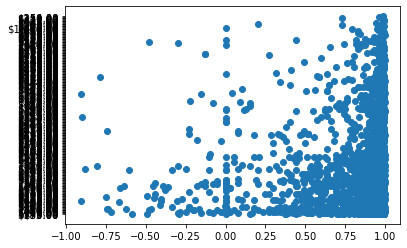

In [63]:
plt.scatter(x=analyzed_df['description'],y=df['price']);

In [110]:
analyzed_df['sum'] = analyzed_df.sum(axis=1)

In [111]:
analyzed_df

,name,summary,space,description,max,mean,sum
0,0.0000,0.0000,0.8439,0.8439,0.8439,0.421950,2.953650
1,0.4404,-0.6151,0.9958,0.9926,0.9958,0.453425,3.262925
2,0.0000,0.7425,0.9360,0.9665,0.9665,0.661250,4.272750
3,0.0000,0.6369,0.0000,0.6369,0.6369,0.318450,2.229150
4,0.5859,0.8356,0.9077,0.9689,0.9689,0.824525,5.091525
...,...,...,...,...,...,...,...
3813,0.0000,0.0000,0.9885,0.9850,0.9885,0.493375,3.455375
3814,0.0000,0.5574,0.7003,0.5346,0.7003,0.448075,2.940675
3815,0.0000,0.9121,0.0000,0.9121,0.9121,0.456050,3.192350
3816,0.7644,0.8513,0.8960,0.9643,0.9643,0.869000,5.309300


In [100]:
df.price=df.price.str.replace(',','')

In [101]:
df.price = pd.to_numeric(df.price, downcast="float")

-0.01698909779886456

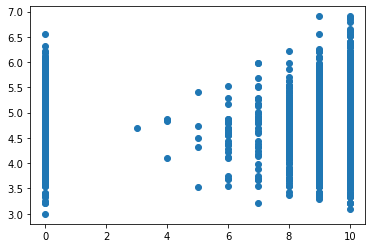

In [132]:
plt.scatter(x=df1['review_scores_cleanliness'],y=np.log(df['price']));
df1['review_scores_cleanliness'].corr((df['price']))

In [128]:
df1= df[['id', 'number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication','review_scores_value']]
df1.fillna(0,inplace=True)

df1['review_scores_total']=df1['review_scores_rating']+df1['review_scores_accuracy']+df1['review_scores_cleanliness']+df1.review_scores_checkin
+df1.review_scores_communication+df1.review_scores_value;

C:\Users\ajax2\anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-128-c7a56fc27881>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['review_scores_total']=df1['review_scores_rating']+df1['review_scores_accuracy']+df1['review_scores_cleanliness']+df1.review_scores_checkin


In [133]:
df=df.drop(['name','summary','space','description','notes','transit','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication','review_scores_value'],axis=1)

In [136]:
df2=df[['amenities']]
df2['amenities']=(df2['amenities']).str.replace('"','')
df2['amenities']=(df2['amenities']).str.strip('/\{}')
df2=df2['amenities'].str.split(',',expand=True)

df3=pd.concat([df1['id'],df2],axis=1)
df3['amenities_count']=df3.apply(lambda x: x.count(), axis=1)
df3

<ipython-input-136-a4efbc945bbc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['amenities']=(df2['amenities']).str.replace('"','')
<ipython-input-136-a4efbc945bbc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['amenities']=(df2['amenities']).str.strip('/\{}')


,id,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,amenities_count
0,241032,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Kitchen,Heating,Family/Kid Friendly,Washer,...,None,None,None,None,None,None,None,None,None,11
1,953595,TV,Internet,Wireless Internet,Kitchen,Free Parking on Premises,Buzzer/Wireless Intercom,Heating,Family/Kid Friendly,Washer,...,None,None,None,None,None,None,None,None,None,17
2,3308979,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Kitchen,Free Parking on Premises,Pets Allowed,Pets live on this property,...,None,None,None,None,None,None,None,None,None,22
3,7421966,Internet,Wireless Internet,Kitchen,Indoor Fireplace,Heating,Family/Kid Friendly,Washer,Dryer,Smoke Detector,...,None,None,None,None,None,None,None,None,None,15
4,278830,TV,Cable TV,Internet,Wireless Internet,Kitchen,Heating,Family/Kid Friendly,Smoke Detector,Carbon Monoxide Detector,...,None,None,None,None,None,None,None,None,None,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,TV,Cable TV,Internet,Wireless Internet,Air Conditioning,Wheelchair Accessible,Kitchen,Free Parking on Premises,Heating,...,None,None,None,None,None,None,None,None,None,17
3814,8902327,TV,Cable TV,Internet,Wireless Internet,Kitchen,Free Parking on Premises,Heating,Family/Kid Friendly,Smoke Detector,...,None,None,None,None,None,None,None,None,None,18
3815,10267360,Cable TV,Wireless Internet,Kitchen,Free Parking on Premises,Breakfast,Pets live on this property,Dog(s),Cat(s),Heating,...,None,None,None,None,None,None,None,None,None,21
3816,9604740,TV,Wireless Internet,Kitchen,Free Parking on Premises,Elevator in Building,Heating,Smoke Detector,Essentials,Hangers,...,None,None,None,None,None,None,None,None,None,12


0.1841758191696443

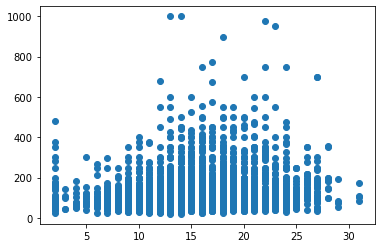

In [138]:
plt.scatter(x=df3['amenities_count'],y=(df['price']));
df3['amenities_count'].corr((df['price']))